# A/B Experiment

## Introduction

## Statistical test

In [1]:
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
from ipywidgets import interact

## Estimating needed sample size

One of the most accurate and used ways to estimate sample size n using the statistical significance and power and the minimum detectable effect (MDE) is the following formula from [[1]](#1):

$$ n'=\frac{\left (  z_{\alpha/2}\sqrt{\strut2\bar{P}\bar{Q}} + z_{\beta}\sqrt{\strut P_1Q_1 + P_2Q_2}\right )^{2}}{\left ( P_2 - P_1 \right )^2}$$

</br>
$$ n = \dfrac{n'}{4}\left ( 1+\sqrt{\strut1+\dfrac{4}{n'\left | P_2 - P_1 \right |}}\right)^2 $$

where :

- $n'$ is sample size without correction and $n$ is sample size with the correction
- $P_1$ and $P_2$ are the population proportions (baseline and expected)
- $Q_i = 1 - P_i$
- $\bar{P}=\frac{P_1 + P_2}{2}$
- $z_{\alpha/2}$ is the cutoff value of probability $\alpha/2$ ($\alpha$ the probability of a type I error) in the standard normal distribution
- $z_{\beta}$ is the cutoff value of probability $\beta$ in the standard normal distribution ($\beta$ the probability of a type II error, or 1 - power)

It is quite easy to change this formula to one that is expressed in function of $p$, the baseline proportion (or probability) and the MDE $\Delta$ by setting $p_1=p$ and $p_2 = p_1 + \Delta$.

In the case presented, $P_1$, the (known) baseline probability is 7% (obtained by previous experiment).
The minimum detectable effect needs to be set by considering the business aspect of the problem, namely, what improvement would be a good outcome if statistically proven or what improvement would be enough to justify the switch to the tested effect. Any improvement smaller than does not need to be statistically detectable as it anyway won't be a success on the business aspect. It is worth noting that the smaller the needed minimum detectable effect, the larger the population size; the reason why it should be chosen wisely. Also, it should be chosen conservatively as there's a possibility that the baseline probability slightly changes during the experiment. Finally, it's important to keep in mind that this MDE is a detectable effect that can be towards both directions, it can be an improvement but also (hopefully not) a deterioration on the CTR.

#### Does that mean that if the resulting effect is less than 4%, it won't be detected ?

No, although this a common misconseption, it means that if the resulting effect is less than 4%, the power of experiment will be less than 90%. That's why a lot of publications started refering to the MDE as Minimum Reliably Detectable Effect (MRDE). More about MDE [here](https://towardsdatascience.com/how-to-set-the-minimum-detectable-effect-in-ab-tests-fe07f8002d6d).

In [2]:
def z_value(p):
    return scipy.stats.norm.ppf(1 - p)

In [3]:
def sample_size(p1, p2, alpha, beta):
    if p1 == p2:
        raise Exception("p1 and p2 can not be the equal")
    q1 = 1 - p1
    q2 = 1 - p2
    pb = (p1+p2) / 2
    qb = (q1+q2) / 2
    npr = (((z_value(alpha/2)*math.sqrt(2*pb*qb))+(z_value(beta)*math.sqrt(p1*q1+p2*q2)))**2)/((p2-p1)**2)
    n = npr*0.25*(1+math.sqrt(1+4/(npr*abs(p2-p1))))**2
    return math.ceil(n)

Here we can play around the p1, p2, alpha and beta values to understand better how does the sample size vary with those parameters

In [4]:
@interact(p1=(0, 1, 0.01), p2=(0, 1, 0.01), alpha=(0, 1, 0.01), beta=(0, 1, 0.01))
def sample_size_interact(p1=0.32, p2=0.36, alpha=0.05, beta=0.1):
    return "Sample size :  {}".format(sample_size(p1, p2, alpha, beta))

interactive(children=(FloatSlider(value=0.32, description='p1', max=1.0, step=0.01), FloatSlider(value=0.36, d…

## Recommenders experiment

Considering the case presented here, the baseline click-through rate is reported to be 7%. The objective of the team is to increase the recommender click-through rate to at least 4% or else the change wouldn't be worth implementing. So the minimum desired expected proportion is 11%

In [5]:
sample_size(0.07, 0.11, 0.05, 0.1)

1124

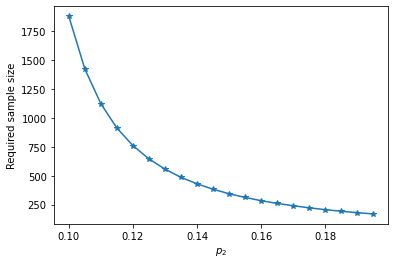

In [6]:
possible_p2 = list(np.arange(0.1, 0.20, 0.005))
samples_sizes = [sample_size(0.07, p2, 0.05, 0.1) for p2 in possible_p2]
plt.plot(possible_p2, samples_sizes, marker='*')
plt.xlabel("$p_2$")
plt.ylabel("Required sample size")
plt.show()

To correctly run the experiment, the sample size must be at least **1124 user** per recommender. 

The experiment will be ran until each recommender has been tested with at least 1130 users.

## References
<a id='1'>[1]</a> Fleiss, J. L. (1973). Statistical methods for rates and proportions. p. 75 New York: J. Wiley.